In [1]:
import torch
import os
import rasterio
import yaml
from train import create_dataloader
import numpy as np
import matplotlib.pyplot as plt
from model import CustomResNet18
from torch.nn.functional import softmax
import pandas as pd


In [49]:
# Load cfgs and dataset:
cfg = yaml.safe_load(open('/home/Mariam/codes/ct_classifier/configs/exp_resnet18.yaml', 'r'))
dl_train = create_dataloader(cfg, split='train',eval=True)
dl_val = create_dataloader(cfg, split='val', eval=True)
#create model instance
model_instance = CustomResNet18(cfg['num_classes']) 
# load a pretrained checkpoint
checkpoint_path = '/home/Mariam/codes/ct_classifier/model_states/100.pt'
state = torch.load(open(checkpoint_path, 'rb'), map_location='cpu')
model_instance.load_state_dict(state['model'])
model_instance.eval()

/home/Mariam/miniconda3/envs/coral/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/Mariam/miniconda3/envs/coral/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_364939/1155033635.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

CustomResNet18(
  (feature_extractor): ResNet(
    (conv1): Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [53]:
def get_model_preds(dataloader,model,device='cpu'):
    all_labels = []
    all_preds = []
    all_softmax = []
    all_image_id1 = []
    all_image_id2 = []
    model.eval()
    model.to(device)
    for idx, (data, labels,image_couples) in enumerate(dataloader):   
        image_idx1, image_idx2 =  image_couples
        data=data.to(device)
        with torch.no_grad():
            predictions = model(data).to('cpu')
        softmax_scores = softmax(predictions,dim=1)
        all_labels.append(labels)
        all_preds.append(predictions)
        all_softmax.append(softmax_scores)
        all_image_id1.append(image_idx1)
        all_image_id2.append(image_idx2)
    all_labels = np.concatenate(all_labels)
    str_labels = ['bleached' if l==1 else 'healthy' for l in all_labels]
    #print(np.concatenate(all_image_id1).shape,np.concatenate(all_image_id2).shape,np.concatenate(all_softmax).shape, )
    df = pd.DataFrame({'image_id1':np.concatenate(all_image_id1),'image_id2':np.concatenate(all_image_id2), 'softmax_bleach_scores':np.concatenate(all_softmax)[:,1],
                         'raw_bleach_scores':np.concatenate(all_preds)[:,1],'labels': all_labels, 'str_labels':str_labels} )
    df['image_path1'] = df.image_id1.map(lambda idx: dataloader.dataset.meta.query('image_id==@idx').filepath.values[0]) # get image paths
    df['image_path2'] = df.image_id2.map(lambda idx: dataloader.dataset.meta.query('image_id==@idx').filepath.values[0])
    df['site'] = df.image_id1.map(lambda idx: dataloader.dataset.meta.query('image_id==@idx').site.values[0])
    df['filename']= df.image_id1.map(lambda idx: dataloader.dataset.meta.query('image_id==@idx').filename.values[0])
    return df

In [39]:
train_scores_df = get_model_preds(dl_train,model_instance)

In [40]:
train_scores_df

,image_id1,image_id2,softmax_bleach_scores,raw_bleach_scores,labels,str_labels,image_path1,image_path2,site,filename
0,18,72,0.998253,3.216250,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,cheeca_flkeys,loc005.tif
1,156,151,0.001951,-4.171565,0.0,healthy,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,northpoint_lizard,loc001.tif
2,9,51,0.999180,3.575939,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,cheeca_flkeys,loc004.tif
3,149,176,0.995477,2.814723,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,northpoint_lizard,loc001.tif
4,153,173,0.997093,2.906343,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,northpoint_lizard,loc001.tif
...,...,...,...,...,...,...,...,...,...,...
1050,10,70,0.998572,2.957212,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,cheeca_flkeys,loc006.tif
1051,161,152,0.000192,-4.748058,0.0,healthy,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,northpoint_lizard,loc001.tif
1052,11,89,0.995890,2.578465,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,cheeca_flkeys,loc001.tif
1053,150,167,0.999644,3.995313,1.0,bleached,/mnt/class_data/group3_remotesensing/mariamaya...,/mnt/class_data/group3_remotesensing/mariamaya...,northpoint_lizard,loc001.tif


In [15]:
softmax_scores = softmax(predictions)
accuracy = sum(labels==softmax_scores.argmax(dim=1))/len(labels)

/tmp/ipykernel_364939/1245490207.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_scores = softmax(predictions)


In [16]:
bleached_scores = softmax_scores[labels==1,1].numpy() # predictions for bleached samples
healthy_scores = softmax_scores[labels==0,1].numpy()# predictions for healthy samples

(array([5., 3., 1., 0., 0., 2., 0., 0., 3., 8.]),
 array([1.95542088e-04, 1.00034617e-01, 1.99873686e-01, 2.99712777e-01,
        3.99551839e-01, 4.99390930e-01, 5.99229991e-01, 6.99069083e-01,
        7.98908174e-01, 8.98747206e-01, 9.98586297e-01]),
 <BarContainer object of 10 artists>)

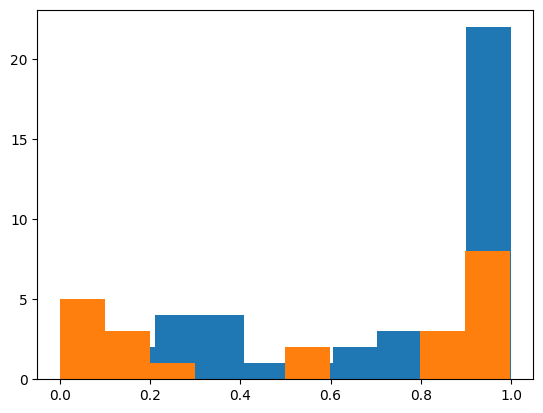

In [17]:
plt.hist(bleached_scores)
plt.hist(healthy_scores)

In [18]:
softmax_scores

tensor([[2.6221e-03, 9.9738e-01],
        [7.5173e-03, 9.9248e-01],
        [2.0342e-01, 7.9658e-01],
        [4.3136e-02, 9.5686e-01],
        [2.9424e-02, 9.7058e-01],
        [5.8833e-01, 4.1167e-01],
        [4.1248e-03, 9.9588e-01],
        [8.4835e-03, 9.9152e-01],
        [8.4887e-01, 1.5113e-01],
        [6.0980e-02, 9.3902e-01],
        [9.6025e-03, 9.9040e-01],
        [6.8627e-01, 3.1373e-01],
        [4.7307e-03, 9.9527e-01],
        [1.7196e-03, 9.9828e-01],
        [2.6088e-01, 7.3912e-01],
        [9.1125e-01, 8.8751e-02],
        [7.0246e-02, 9.2975e-01],
        [6.8005e-01, 3.1995e-01],
        [1.4380e-03, 9.9856e-01],
        [7.0556e-03, 9.9294e-01],
        [9.2703e-02, 9.0730e-01],
        [7.9072e-01, 2.0928e-01],
        [1.1167e-01, 8.8833e-01],
        [7.1271e-01, 2.8729e-01],
        [1.4138e-03, 9.9859e-01],
        [7.2702e-02, 9.2730e-01],
        [8.7864e-01, 1.2136e-01],
        [4.8556e-01, 5.1444e-01],
        [6.6261e-01, 3.3739e-01],
        [9.518

In [20]:
str_labels = ['bleached' if l==1 else 'healthy' for l in labels]

scores_df = pd.DataFrame({'image_id1':image_idx1,'image_id2':image_idx2, 'softmax_bleach_scores':softmax_scores[:,1].numpy(),
                         'raw_bleach_scores':predictions[:,1].numpy(),'labels': labels, 'str_labels':str_labels} )
scores_df['image_path1'] = scores_df.image_id1.map(lambda idx: dl_val.dataset.meta.query('image_id==@idx').filepath.values[0]) # get image paths
scores_df['image_path2'] = scores_df.image_id2.map(lambda idx: dl_val.dataset.meta.query('image_id==@idx').filepath.values[0])
scores_df['site'] = scores_df.image_id1.map(lambda idx: dl_val.dataset.meta.query('image_id==@idx').site.values[0])
scores_df['filename']= scores_df.image_id1.map(lambda idx: dl_val.dataset.meta.query('image_id==@idx').filename.values[0])
#scores_df['date1']
#scores_df['date2']

In [21]:
scores_df.site.unique()

array(['cheeca_flkeys', 'lbcaye_bbr', 'sanagustin_mexico',
       'northpoint_lizard'], dtype=object)

str_labels
bleached    Axes(0.125,0.11;0.775x0.77)
healthy     Axes(0.125,0.11;0.775x0.77)
Name: softmax_bleach_scores, dtype: object

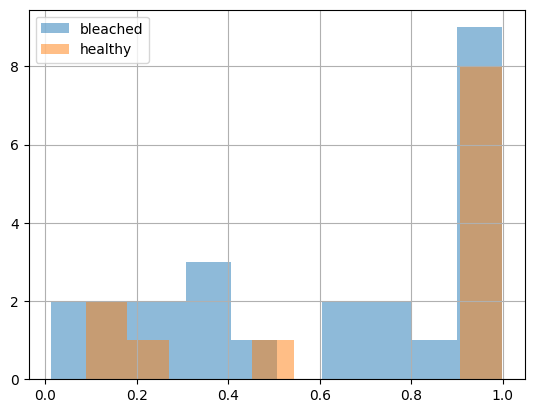

In [27]:
scores_df[scores_df.site=='cheeca_flkeys'].groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True)

In [54]:
train_scores_df = get_model_preds(dl_train,model_instance,device='cuda')
val_scores_df = get_model_preds(dl_val,model_instance,device='cuda')

str_labels
bleached    Axes(0.125,0.11;0.775x0.77)
healthy     Axes(0.125,0.11;0.775x0.77)
Name: raw_bleach_scores, dtype: object

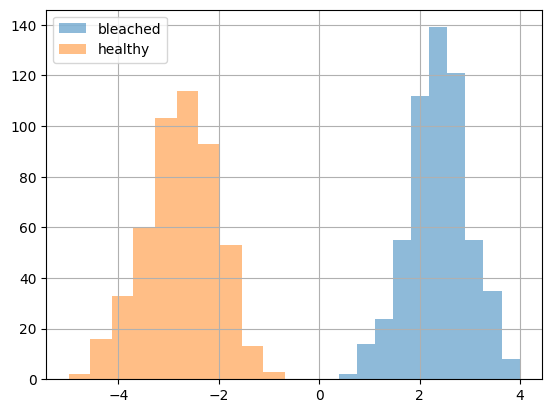

In [55]:
train_scores_df.groupby('str_labels').raw_bleach_scores.hist(alpha=0.5,legend=True)

str_labels
bleached    Axes(0.125,0.11;0.775x0.77)
healthy     Axes(0.125,0.11;0.775x0.77)
Name: softmax_bleach_scores, dtype: object

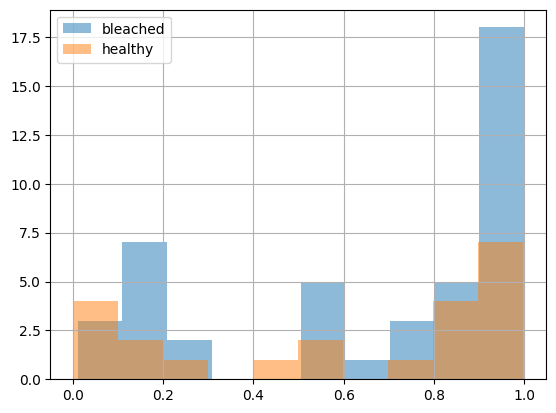

In [58]:
val_scores_df.groupby('str_labels').softmax_bleach_scores.hist(alpha=0.5,legend=True)